In [28]:
import dualcodec
import torchaudio
import torch
import matplotlib.pyplot as plotter
from IPython.display import Audio

In [ ]:
# v3 is the averaged models (so we can supply custom names of safetensors)

model_id = "12hz_v3"

path = "/home/vansh/dualcodec-exp/averaged_models"
name = "averaged_model_step_1030000_decay_0.9.safetensors"


In [ ]:
dualcodec_model = dualcodec.get_model(model_id, path, name=name)

In [ ]:
DEVICE = "cuda"

In [ ]:
dualcodec_inference = dualcodec.Inference(dualcodec_model=dualcodec_model, device=DEVICE)

In [ ]:
audio, sr = torchaudio.load("audio_samples/tara.wav")
audio = torchaudio.functional.resample(audio, sr, 24000)
audio = audio.reshape(1,1,-1)
Audio(audio.squeeze(0), rate=24000)

In [ ]:
audio = audio.to(DEVICE)
semantic_codes, acoustic_codes = dualcodec_inference.encode(audio, n_quantizers=8)

In [ ]:
out_audio = dualcodec_inference.decode(semantic_codes, acoustic_codes)
Audio(out_audio.cpu().squeeze(0), rate=24000)

In [ ]:
model_id_base = "12hz_v1"
dualcodec_model_base = dualcodec.get_model(model_id_base)
dualcodec_inference_base = dualcodec.Inference(dualcodec_model=dualcodec_model_base, device=DEVICE)

In [14]:
semantic_codes_base, acoustic_codes_base = dualcodec_inference_base.encode(audio, n_quantizers=8)

In [15]:
out_audio_base = dualcodec_inference_base.decode(semantic_codes_base, acoustic_codes_base)
Audio(out_audio_base.cpu().squeeze(0), rate=24000)

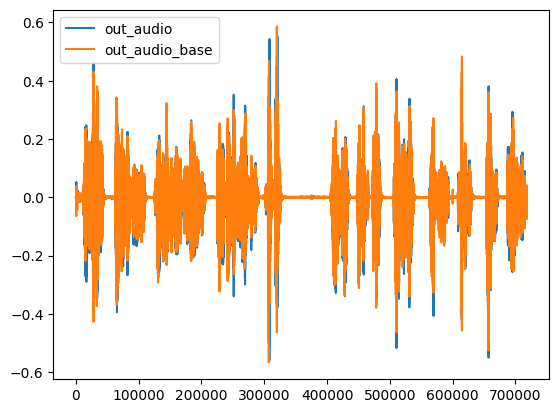

In [16]:
# plot out_audio_base and out_audio on the same plot and theen plot theor difference
plotter.plot(out_audio.cpu().squeeze(0).squeeze(0), label="out_audio")
plotter.plot(out_audio_base.cpu().squeeze(0).squeeze(0),  label="out_audio_base")
plotter.legend()
plotter.show()

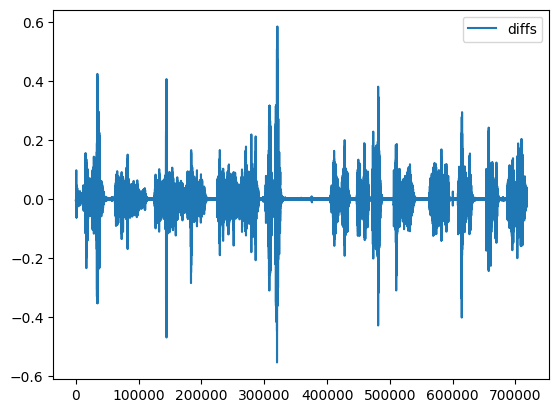

In [17]:
diffs = out_audio - out_audio_base
plotter.plot(diffs.cpu().squeeze(0).squeeze(0), label="diffs")
plotter.legend()
plotter.show()

### Check

In [ ]:
from datasets import load_dataset
import os

local_dir = "/mnt/disks/emilia/emilia_dataset/Emilia/EN"
tar_paths = [filename for filename in os.listdir(local_dir) if filename.endswith(".tar")]
language = "EN"
            
dataset = load_dataset(
    local_dir,
    data_files={language.lower(): tar_paths},
    split=language.lower(),
    num_proc=40,
    cache_dir="/mnt/disks/emilia/emilia_cache",
)

In [33]:
from datasets import load_dataset

ds = load_dataset(
    "vanshjjw/amu-pushed-tara-1000r",
    split="train",
)

ds2 = load_dataset(
    "amphion/Emilia-Dataset",
    split="train",
    streaming=True,
)
        

In [37]:
samples = []
for example in ds:
    if "audio" not in example or example["audio"] is None:
        continue
    audio_dict = example["audio"]
    waveform = torch.tensor(audio_dict["array"], dtype=torch.float32).unsqueeze(0)
    sr = int(audio_dict["sampling_rate"])
    
    if sr != 24000:
        waveform = torchaudio.functional.resample(waveform, sr, 24000)
    
    samples.append(
        {
            "mp3": {
                "array": waveform.numpy(),
                "sampling_rate": 24000,
            },
        }
    )